<h1>导入数据</h1>

In [43]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import time
import tensorflow.keras.backend as K
import keras_metrics as km
from datetime import datetime
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from tensorflow.keras.layers import Input, Dense, LSTM, MaxPool1D, Dropout, concatenate, Flatten, Conv1D, Lambda, BatchNormalization, ReLU, Activation, TimeDistributed, RepeatVector
from tensorflow.keras.callbacks import History, TensorBoard, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.losses import Hinge
from tensorflow.keras.metrics import Precision, Recall
from tensorflow_addons.metrics import F1Score
from tensorflow.keras.backend import clear_session, epsilon
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, save_model, load_model, Sequential
from time import strftime, localtime
from itertools import combinations
from scipy.spatial import distance

<h1>数据处理</h1>

<h2>数据预处理</h2>

<h3>conf_info数据预处理</h3>

In [2]:
cons_info = pd.read_csv("../data/训练组_比特币挖矿_档案明细（20211220）.csv", index_col=0, quotechar='"', encoding="gbk")
cons_info

,ID,ELEC_TYPE_NAME,VOLT_NAME,PRC_NAME,CONTRACT_CAP,RUN_CAP,SHIFT_NO,BUILD_DATE,CANCEL_DATE,CHK_CYCLE,LAST_CHK_DATE,TMP_NAME,TMP_DATE,IS_FLAG
,,,,,,,,,,,,,,
1,329465205,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,4.0,4.0,1.0,2005/6/18,NaN,240.0,2005/6/18,非临时用电,NaN,0
2,329465245,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,4.0,4.0,1.0,2005/6/18,NaN,240.0,2005/6/18,非临时用电,NaN,0
3,329465357,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,8.0,8.0,1.0,2005/6/18,NaN,240.0,2005/6/18,非临时用电,NaN,0
4,329465360,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,2.0,2.0,1.0,2005/6/18,NaN,240.0,2005/6/18,非临时用电,NaN,0
5,329465439,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,8.0,8.0,1.0,2005/6/18,NaN,240.0,2005/6/18,非临时用电,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8836,2862711473,乡村居民生活用电,交流380V,居民合表电价(不满1千伏）,39.0,39.0,NaN,2019/12/2 16:12:00,NaN,120.0,2019/12/2 16:12:00,非临时用电,NaN,0
8837,2864274650,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,13.0,13.0,NaN,2019/12/3 16:33:00,NaN,120.0,2019/12/3 16:33:00,非临时用电,NaN,0
8838,2872313739,乡村居民生活用电,交流380V,居民合表电价(不满1千伏）,39.0,39.0,NaN,2019/12/18 14:42:00,NaN,120.0,2019/12/18 14:42:00,非临时用电,NaN,0


In [3]:
cons_info = cons_info.set_index("ID").drop(columns=["CANCEL_DATE", "TMP_DATE"])
cons_info

,ELEC_TYPE_NAME,VOLT_NAME,PRC_NAME,CONTRACT_CAP,RUN_CAP,SHIFT_NO,BUILD_DATE,CHK_CYCLE,LAST_CHK_DATE,TMP_NAME,IS_FLAG
ID,,,,,,,,,,,
329465205,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,4.0,4.0,1.0,2005/6/18,240.0,2005/6/18,非临时用电,0
329465245,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,4.0,4.0,1.0,2005/6/18,240.0,2005/6/18,非临时用电,0
329465357,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,8.0,8.0,1.0,2005/6/18,240.0,2005/6/18,非临时用电,0
329465360,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,2.0,2.0,1.0,2005/6/18,240.0,2005/6/18,非临时用电,0
329465439,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,8.0,8.0,1.0,2005/6/18,240.0,2005/6/18,非临时用电,0
...,...,...,...,...,...,...,...,...,...,...,...
2862711473,乡村居民生活用电,交流380V,居民合表电价(不满1千伏）,39.0,39.0,NaN,2019/12/2 16:12:00,120.0,2019/12/2 16:12:00,非临时用电,0
2864274650,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,13.0,13.0,NaN,2019/12/3 16:33:00,120.0,2019/12/3 16:33:00,非临时用电,0
2872313739,乡村居民生活用电,交流380V,居民合表电价(不满1千伏）,39.0,39.0,NaN,2019/12/18 14:42:00,120.0,2019/12/18 14:42:00,非临时用电,0


In [4]:
cons_info["BUILD_DATE"] = pd.to_datetime(cons_info["BUILD_DATE"])
cons_info["LAST_CHK_DATE"] = pd.to_datetime(cons_info["LAST_CHK_DATE"])
cons_info

,ELEC_TYPE_NAME,VOLT_NAME,PRC_NAME,CONTRACT_CAP,RUN_CAP,SHIFT_NO,BUILD_DATE,CHK_CYCLE,LAST_CHK_DATE,TMP_NAME,IS_FLAG
ID,,,,,,,,,,,
329465205,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,4.0,4.0,1.0,2005-06-18 00:00:00,240.0,2005-06-18 00:00:00,非临时用电,0
329465245,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,4.0,4.0,1.0,2005-06-18 00:00:00,240.0,2005-06-18 00:00:00,非临时用电,0
329465357,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,8.0,8.0,1.0,2005-06-18 00:00:00,240.0,2005-06-18 00:00:00,非临时用电,0
329465360,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,2.0,2.0,1.0,2005-06-18 00:00:00,240.0,2005-06-18 00:00:00,非临时用电,0
329465439,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,8.0,8.0,1.0,2005-06-18 00:00:00,240.0,2005-06-18 00:00:00,非临时用电,0
...,...,...,...,...,...,...,...,...,...,...,...
2862711473,乡村居民生活用电,交流380V,居民合表电价(不满1千伏）,39.0,39.0,NaN,2019-12-02 16:12:00,120.0,2019-12-02 16:12:00,非临时用电,0
2864274650,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,13.0,13.0,NaN,2019-12-03 16:33:00,120.0,2019-12-03 16:33:00,非临时用电,0
2872313739,乡村居民生活用电,交流380V,居民合表电价(不满1千伏）,39.0,39.0,NaN,2019-12-18 14:42:00,120.0,2019-12-18 14:42:00,非临时用电,0


In [5]:
cons_info["SHIFT_NO"] = cons_info["SHIFT_NO"].fillna(0)
cons_info

,ELEC_TYPE_NAME,VOLT_NAME,PRC_NAME,CONTRACT_CAP,RUN_CAP,SHIFT_NO,BUILD_DATE,CHK_CYCLE,LAST_CHK_DATE,TMP_NAME,IS_FLAG
ID,,,,,,,,,,,
329465205,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,4.0,4.0,1.0,2005-06-18 00:00:00,240.0,2005-06-18 00:00:00,非临时用电,0
329465245,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,4.0,4.0,1.0,2005-06-18 00:00:00,240.0,2005-06-18 00:00:00,非临时用电,0
329465357,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,8.0,8.0,1.0,2005-06-18 00:00:00,240.0,2005-06-18 00:00:00,非临时用电,0
329465360,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,2.0,2.0,1.0,2005-06-18 00:00:00,240.0,2005-06-18 00:00:00,非临时用电,0
329465439,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,8.0,8.0,1.0,2005-06-18 00:00:00,240.0,2005-06-18 00:00:00,非临时用电,0
...,...,...,...,...,...,...,...,...,...,...,...
2862711473,乡村居民生活用电,交流380V,居民合表电价(不满1千伏）,39.0,39.0,0.0,2019-12-02 16:12:00,120.0,2019-12-02 16:12:00,非临时用电,0
2864274650,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,13.0,13.0,0.0,2019-12-03 16:33:00,120.0,2019-12-03 16:33:00,非临时用电,0
2872313739,乡村居民生活用电,交流380V,居民合表电价(不满1千伏）,39.0,39.0,0.0,2019-12-18 14:42:00,120.0,2019-12-18 14:42:00,非临时用电,0


In [6]:
cons_info["now"] = "2021-12-31"
cons_info["now"] = pd.to_datetime(cons_info["now"])
cons_info

,ELEC_TYPE_NAME,VOLT_NAME,PRC_NAME,CONTRACT_CAP,RUN_CAP,SHIFT_NO,BUILD_DATE,CHK_CYCLE,LAST_CHK_DATE,TMP_NAME,IS_FLAG,now
ID,,,,,,,,,,,,
329465205,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,4.0,4.0,1.0,2005-06-18 00:00:00,240.0,2005-06-18 00:00:00,非临时用电,0,2021-12-31
329465245,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,4.0,4.0,1.0,2005-06-18 00:00:00,240.0,2005-06-18 00:00:00,非临时用电,0,2021-12-31
329465357,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,8.0,8.0,1.0,2005-06-18 00:00:00,240.0,2005-06-18 00:00:00,非临时用电,0,2021-12-31
329465360,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,2.0,2.0,1.0,2005-06-18 00:00:00,240.0,2005-06-18 00:00:00,非临时用电,0,2021-12-31
329465439,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,8.0,8.0,1.0,2005-06-18 00:00:00,240.0,2005-06-18 00:00:00,非临时用电,0,2021-12-31
...,...,...,...,...,...,...,...,...,...,...,...,...
2862711473,乡村居民生活用电,交流380V,居民合表电价(不满1千伏）,39.0,39.0,0.0,2019-12-02 16:12:00,120.0,2019-12-02 16:12:00,非临时用电,0,2021-12-31
2864274650,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,13.0,13.0,0.0,2019-12-03 16:33:00,120.0,2019-12-03 16:33:00,非临时用电,0,2021-12-31
2872313739,乡村居民生活用电,交流380V,居民合表电价(不满1千伏）,39.0,39.0,0.0,2019-12-18 14:42:00,120.0,2019-12-18 14:42:00,非临时用电,0,2021-12-31


In [7]:
cons_info["live_days"] = (cons_info["now"] - cons_info["BUILD_DATE"]).map(lambda x: x.days)
cons_info["check_days"] = (cons_info["now"] - cons_info["LAST_CHK_DATE"]).map(lambda x: x.days)
cons_info

,ELEC_TYPE_NAME,VOLT_NAME,PRC_NAME,CONTRACT_CAP,RUN_CAP,SHIFT_NO,BUILD_DATE,CHK_CYCLE,LAST_CHK_DATE,TMP_NAME,IS_FLAG,now,live_days,check_days
ID,,,,,,,,,,,,,,
329465205,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,4.0,4.0,1.0,2005-06-18 00:00:00,240.0,2005-06-18 00:00:00,非临时用电,0,2021-12-31,6040,6040
329465245,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,4.0,4.0,1.0,2005-06-18 00:00:00,240.0,2005-06-18 00:00:00,非临时用电,0,2021-12-31,6040,6040
329465357,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,8.0,8.0,1.0,2005-06-18 00:00:00,240.0,2005-06-18 00:00:00,非临时用电,0,2021-12-31,6040,6040
329465360,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,2.0,2.0,1.0,2005-06-18 00:00:00,240.0,2005-06-18 00:00:00,非临时用电,0,2021-12-31,6040,6040
329465439,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,8.0,8.0,1.0,2005-06-18 00:00:00,240.0,2005-06-18 00:00:00,非临时用电,0,2021-12-31,6040,6040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2862711473,乡村居民生活用电,交流380V,居民合表电价(不满1千伏）,39.0,39.0,0.0,2019-12-02 16:12:00,120.0,2019-12-02 16:12:00,非临时用电,0,2021-12-31,759,759
2864274650,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,13.0,13.0,0.0,2019-12-03 16:33:00,120.0,2019-12-03 16:33:00,非临时用电,0,2021-12-31,758,758
2872313739,乡村居民生活用电,交流380V,居民合表电价(不满1千伏）,39.0,39.0,0.0,2019-12-18 14:42:00,120.0,2019-12-18 14:42:00,非临时用电,0,2021-12-31,743,743


In [8]:
cons_info = cons_info.drop(columns=["BUILD_DATE", "LAST_CHK_DATE", "now"])
cons_info

,ELEC_TYPE_NAME,VOLT_NAME,PRC_NAME,CONTRACT_CAP,RUN_CAP,SHIFT_NO,CHK_CYCLE,TMP_NAME,IS_FLAG,live_days,check_days
ID,,,,,,,,,,,
329465205,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,4.0,4.0,1.0,240.0,非临时用电,0,6040,6040
329465245,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,4.0,4.0,1.0,240.0,非临时用电,0,6040,6040
329465357,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,8.0,8.0,1.0,240.0,非临时用电,0,6040,6040
329465360,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,2.0,2.0,1.0,240.0,非临时用电,0,6040,6040
329465439,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,8.0,8.0,1.0,240.0,非临时用电,0,6040,6040
...,...,...,...,...,...,...,...,...,...,...,...
2862711473,乡村居民生活用电,交流380V,居民合表电价(不满1千伏）,39.0,39.0,0.0,120.0,非临时用电,0,759,759
2864274650,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,13.0,13.0,0.0,120.0,非临时用电,0,758,758
2872313739,乡村居民生活用电,交流380V,居民合表电价(不满1千伏）,39.0,39.0,0.0,120.0,非临时用电,0,743,743


In [9]:
cons_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8840 entries, 329465205 to 2529558569
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ELEC_TYPE_NAME  8840 non-null   object 
 1   VOLT_NAME       8840 non-null   object 
 2   PRC_NAME        8840 non-null   object 
 3   CONTRACT_CAP    8840 non-null   float64
 4   RUN_CAP         8840 non-null   float64
 5   SHIFT_NO        8840 non-null   float64
 6   CHK_CYCLE       8838 non-null   float64
 7   TMP_NAME        8840 non-null   object 
 8   IS_FLAG         8840 non-null   int64  
 9   live_days       8840 non-null   int64  
 10  check_days      8840 non-null   int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 828.8+ KB


In [10]:
cons_info = pd.get_dummies(cons_info)
cons_info

,CONTRACT_CAP,RUN_CAP,SHIFT_NO,CHK_CYCLE,IS_FLAG,live_days,check_days,ELEC_TYPE_NAME_乡村居民生活用电,ELEC_TYPE_NAME_商业用电,ELEC_TYPE_NAME_城镇居民生活用电,...,ELEC_TYPE_NAME_居民生活用电,ELEC_TYPE_NAME_普通工业,ELEC_TYPE_NAME_非居民照明,ELEC_TYPE_NAME_非工业,VOLT_NAME_交流10kV,VOLT_NAME_交流220V,VOLT_NAME_交流380V,PRC_NAME_居民合表电价(1-10千伏）,PRC_NAME_居民合表电价(不满1千伏）,TMP_NAME_非临时用电
ID,,,,,,,,,,,,,,,,,,,,,
329465205,4.0,4.0,1.0,240.0,0,6040,6040,1,0,0,...,0,0,0,0,0,1,0,0,1,1
329465245,4.0,4.0,1.0,240.0,0,6040,6040,1,0,0,...,0,0,0,0,0,1,0,0,1,1
329465357,8.0,8.0,1.0,240.0,0,6040,6040,1,0,0,...,0,0,0,0,0,1,0,0,1,1
329465360,2.0,2.0,1.0,240.0,0,6040,6040,1,0,0,...,0,0,0,0,0,1,0,0,1,1
329465439,8.0,8.0,1.0,240.0,0,6040,6040,1,0,0,...,0,0,0,0,0,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2862711473,39.0,39.0,0.0,120.0,0,759,759,1,0,0,...,0,0,0,0,0,0,1,0,1,1
2864274650,13.0,13.0,0.0,120.0,0,758,758,1,0,0,...,0,0,0,0,0,1,0,0,1,1
2872313739,39.0,39.0,0.0,120.0,0,743,743,1,0,0,...,0,0,0,0,0,0,1,0,1,1


In [11]:
cons_info["CHK_CYCLE"] = cons_info["CHK_CYCLE"].fillna(cons_info["CHK_CYCLE"].median())
cons_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8840 entries, 329465205 to 2529558569
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   CONTRACT_CAP                8840 non-null   float64
 1   RUN_CAP                     8840 non-null   float64
 2   SHIFT_NO                    8840 non-null   float64
 3   CHK_CYCLE                   8840 non-null   float64
 4   IS_FLAG                     8840 non-null   int64  
 5   live_days                   8840 non-null   int64  
 6   check_days                  8840 non-null   int64  
 7   ELEC_TYPE_NAME_乡村居民生活用电     8840 non-null   uint8  
 8   ELEC_TYPE_NAME_商业用电         8840 non-null   uint8  
 9   ELEC_TYPE_NAME_城镇居民生活用电     8840 non-null   uint8  
 10  ELEC_TYPE_NAME_学校教学和学生生活用电  8840 non-null   uint8  
 11  ELEC_TYPE_NAME_居民生活用电       8840 non-null   uint8  
 12  ELEC_TYPE_NAME_普通工业         8840 non-null   uint8  
 13  ELEC_TYPE_NAME_非居民照

<h3>elec_month数据预处理</h3>

In [12]:
elec_month = pd.read_csv("../data/训练组_比特币挖矿_月用电明细（20211217）.csv")
elec_month

,id,ym,pq_f,pq_g,pq_p,pq_z
0,329769614,202001,615,161,0,776
1,329769614,202002,492,154,-1,645
2,329769614,202003,457,114,1,572
3,329769614,202004,522,171,0,693
4,329769614,202005,519,181,0,700
...,...,...,...,...,...,...
194475,2878334859,202106,107,67,-1,173
194476,2878334859,202107,170,112,1,283
194477,2878334859,202108,102,67,0,169
194478,2878334859,202109,112,65,-1,176


In [13]:
elec_month["ym"] = elec_month["ym"].astype(str)
elec_month

,id,ym,pq_f,pq_g,pq_p,pq_z
0,329769614,202001,615,161,0,776
1,329769614,202002,492,154,-1,645
2,329769614,202003,457,114,1,572
3,329769614,202004,522,171,0,693
4,329769614,202005,519,181,0,700
...,...,...,...,...,...,...
194475,2878334859,202106,107,67,-1,173
194476,2878334859,202107,170,112,1,283
194477,2878334859,202108,102,67,0,169
194478,2878334859,202109,112,65,-1,176


elec_month[["pq_f", "pq_g", "pq_p", "pq_z"]] = elec_month[["pq_f", "pq_g", "pq_p", "pq_z"]] / elec_month[["pq_f", "pq_g", "pq_p", "pq_z"]].max(axis=0)
elec_month

In [14]:
cons_month_result = []
for cons_id in tqdm(cons_info.index):
    df = elec_month[elec_month["id"] == cons_id]
    df = df.drop(columns=["id"]).sort_values("ym").set_index("ym")
    df = df.fillna(method="ffill").fillna(method="bfill").fillna(0)
    
    cons_month_result.append(df.values)
cons_month = np.array(cons_month_result)
cons_month.shape

100%|███████████████████████████████████████████████████████████████████████████████| 8840/8840 [00:12<00:00, 686.59it/s]


(8840, 22, 4)

<h3>elec_day数据预处理</h3>

In [15]:
elec_day = pd.read_csv("../data/训练组_比特币挖矿_日用电明细（20211217）.csv")
elec_day

,id,rq,kwh,kwh_rap,kwh_pap_r1,kwh_pap_r2,kwh_pap_r3,kwh_pap_r4
0,329449398,2020-01-22 00:00:00,11.77,0.0,0.0,7.40,0.0,4.36
1,329449398,2020-01-23 00:00:00,16.54,0.0,0.0,8.68,0.0,7.86
2,329449398,2020-01-24 00:00:00,10.86,0.0,0.0,5.51,0.0,5.36
3,329449398,2020-01-25 00:00:00,10.91,0.0,0.0,6.48,0.0,4.43
4,329449398,2020-01-26 00:00:00,10.85,0.0,0.0,6.32,0.0,4.52
...,...,...,...,...,...,...,...,...
954564,2878334859,2021-10-05 00:00:00,7.22,NaN,0.0,4.49,0.0,2.73
954565,2878334859,2021-10-06 00:00:00,7.23,NaN,0.0,4.48,0.0,2.74
954566,2878334859,2021-10-07 00:00:00,7.20,NaN,0.0,4.48,0.0,2.73
954567,2878334859,2021-10-08 00:00:00,7.23,NaN,0.0,4.50,0.0,2.73


elec_day[["kwh", "kwh_rap", "kwh_pap_r1", "kwh_pap_r2", "kwh_pap_r3", "kwh_pap_r4"]] = elec_day[["kwh", "kwh_rap", "kwh_pap_r1", "kwh_pap_r2", "kwh_pap_r3", "kwh_pap_r4"]] / elec_day[["kwh", "kwh_rap", "kwh_pap_r1", "kwh_pap_r2", "kwh_pap_r3", "kwh_pap_r4"]].max(axis=0)
elec_day

In [16]:
dates = pd.to_datetime(elec_day["rq"].unique()).sort_values()

In [17]:
cons_day_result = []
for cons_id in tqdm(cons_info.index):
    df = elec_day[elec_day["id"] == cons_id].drop(columns=["id"]).sort_values("rq")
    df["rq"] = pd.to_datetime(df["rq"])
    df = df.set_index("rq").reindex(dates)
    df = df.fillna(method="ffill").fillna(method="bfill").fillna(0)
    
    cons_day_result.append(df.values)
cons_day = np.array(cons_day_result)
cons_day.shape

100%|███████████████████████████████████████████████████████████████████████████████| 8840/8840 [00:25<00:00, 344.58it/s]


(8840, 108, 6)

<h2>再处理数据</h2>

<h3>查看现有数据形状</h3>

<h4>标签</h4>

In [18]:
target = cons_info["IS_FLAG"].values.astype(np.float64)
target.shape

(8840,)

<h4>统一视图</h4>

In [19]:
cons_info_train = cons_info.drop(columns=["IS_FLAG"]).values
print(cons_info_train.shape)
print(np.isnan(cons_info_train).sum())

(8840, 20)
0


<h4>月均电量</h4>

In [20]:
print(cons_month.shape)
print(np.isnan(cons_month).sum())

(8840, 22, 4)
0


<h4>日电量</h4>

In [21]:
print(cons_day.shape)
print(np.isnan(cons_day).sum())

(8840, 108, 6)
0


<h3>标准化</h3>

In [22]:
def flatten(X):
    '''
    Flatten a 3D array.
    
    Input
    X            A 3D array for lstm, where the array is sample x timesteps x features.
    
    Output
    flattened_X  A 2D array, sample x features.
    '''
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

def scale(X, scaler):
    '''
    Scale 3D array.

    Inputs
    X            A 3D array for lstm, where the array is sample x timesteps x features.
    scaler       A scaler object, e.g., sklearn.preprocessing.StandardScaler, sklearn.preprocessing.normalize
    
    Output
    X            Scaled 3D array.
    '''
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
        
    return X

<h4>月电量的标准化</h4>

In [23]:
# Initialize a scaler using the training data.
month_scaler = StandardScaler().fit(flatten(cons_month))

In [24]:
cons_month_sacled = scale(cons_month, month_scaler)
cons_month_sacled.shape

(8840, 22, 4)

<h4>日电量标准化</h4>

In [25]:
day_scaler = StandardScaler().fit(flatten(cons_day))

In [26]:
cons_day_sacled = scale(cons_day, day_scaler)
cons_day_sacled.shape

(8840, 108, 6)

<h1>构建自编码器</h1>

<h2>初始化tensorflow</h2>

In [27]:
clear_session()
tf.compat.v1.reset_default_graph()
for gpu in tf.config.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(gpu, True)

<h2>构建月电量序列的自编码器</h2>

In [28]:
input_cons_month = Input(shape=cons_month_sacled.shape[1:], name="input_cons_month")
y2, y_hidden_state_1, y_cell_state_1 = LSTM(units=32, return_sequences=True, return_state=True, name="y2")(input_cons_month)
y_hidden_state_2 = Dense(units=64, name="y_hidden_state_2")(y_hidden_state_1)
y_cell_state_2 = Dense(units=64, name="y_cell_state_2")(y_cell_state_1)
y3 = LSTM(units=64, return_sequences=False, return_state=False, name="y3")(y2, [y_hidden_state_2, y_cell_state_2])
y4 = RepeatVector(cons_month_sacled.shape[1], name="y4")(y3)
y5, y_hidden_state_4, y_cell_state_4 = LSTM(units=64, return_sequences=True, return_state=True, name="y5")(y4)
y_hidden_state_5 = Dense(units=32, name="y_hidden_state_5")(y_hidden_state_4)
y_cell_state_5 = Dense(units=32, name="y_cell_state_5")(y_cell_state_4)
y6 = LSTM(units=32, return_sequences=True, return_state=False, name="y6")(y5, [y_hidden_state_5, y_cell_state_5])
y7 = TimeDistributed(Dense(units=cons_month_sacled.shape[-1]))(y6)


month_autoencoder = Model(inputs=[input_cons_month], outputs=[y7], name="month_autoencoder")
month_autoencoder.summary()

Model: "month_autoencoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_cons_month (InputLayer)   [(None, 22, 4)]      0                                            
__________________________________________________________________________________________________
y2 (LSTM)                       [(None, 22, 32), (No 4736        input_cons_month[0][0]           
__________________________________________________________________________________________________
y_hidden_state_2 (Dense)        (None, 64)           2112        y2[0][1]                         
__________________________________________________________________________________________________
y_cell_state_2 (Dense)          (None, 64)           2112        y2[0][2]                         
__________________________________________________________________________________

In [29]:
month_autoencoder.compile(
    loss="mse",
    optimizer=Adam(learning_rate=1e-4),
    metrics=["mse"]
)
month_autoencoder_history = month_autoencoder.fit(
    cons_month_sacled,
    cons_month_sacled,
    validation_split=0.2,
    epochs=200,
    batch_size=64,
    use_multiprocessing=True,
    workers=12,
    callbacks=[
        TensorBoard(log_dir="../logs/%s" % strftime("%Y%m%d_%H.%M.%S", localtime()), write_graph=True, write_images=True),
        ModelCheckpoint(filepath="../models/month_autoencoder.h5", save_best_only=True, verbose=1),
        ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)
    ]
).history

Epoch 1/200
  1/111 [..............................] - ETA: 0s - loss: 0.0682 - mse: 0.0682WARNING:tensorflow:From c:\users\drzon\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
107/111 [===========================>..] - ETA: 0s - loss: 0.7233 - mse: 0.7233
Epoch 00001: val_loss improved from inf to 0.87799, saving model to ../models\month_autoencoder.h5
111/111 [==============================] - 2s 21ms/step - loss: 0.7667 - mse: 0.7667 - val_loss: 0.8780 - val_mse: 0.8780
Epoch 2/200
108/111 [============================>.] - ETA: 0s - loss: 0.5682 - mse: 0.5682
Epoch 00002: val_loss improved from 0.87799 to 0.70648, saving model to ../models\month_autoencoder.h5
111/111 [==============================] - 1s 12ms/step - loss: 0.5596 - mse: 0.5596 - val_loss: 0.706

Epoch 25/200
109/111 [============================>.] - ETA: 0s - loss: 0.2974 - mse: 0.2974
Epoch 00025: val_loss improved from 0.42612 to 0.41998, saving model to ../models\month_autoencoder.h5
111/111 [==============================] - 1s 12ms/step - loss: 0.2940 - mse: 0.2940 - val_loss: 0.4200 - val_mse: 0.4200
Epoch 26/200
110/111 [============================>.] - ETA: 0s - loss: 0.2897 - mse: 0.2897
Epoch 00026: val_loss improved from 0.41998 to 0.41565, saving model to ../models\month_autoencoder.h5
111/111 [==============================] - 1s 12ms/step - loss: 0.2886 - mse: 0.2886 - val_loss: 0.4156 - val_mse: 0.4156
Epoch 27/200
109/111 [============================>.] - ETA: 0s - loss: 0.2773 - mse: 0.2773
Epoch 00027: val_loss improved from 0.41565 to 0.41320, saving model to ../models\month_autoencoder.h5
111/111 [==============================] - 1s 12ms/step - loss: 0.2859 - mse: 0.2859 - val_loss: 0.4132 - val_mse: 0.4132
Epoch 28/200
110/111 [========================

Epoch 51/200
109/111 [============================>.] - ETA: 0s - loss: 0.2326 - mse: 0.2326
Epoch 00051: val_loss improved from 0.33568 to 0.33254, saving model to ../models\month_autoencoder.h5
111/111 [==============================] - 1s 12ms/step - loss: 0.2318 - mse: 0.2318 - val_loss: 0.3325 - val_mse: 0.3325
Epoch 52/200
109/111 [============================>.] - ETA: 0s - loss: 0.2324 - mse: 0.2324
Epoch 00052: val_loss improved from 0.33254 to 0.32872, saving model to ../models\month_autoencoder.h5
111/111 [==============================] - 1s 12ms/step - loss: 0.2299 - mse: 0.2299 - val_loss: 0.3287 - val_mse: 0.3287
Epoch 53/200
111/111 [==============================] - ETA: 0s - loss: 0.2277 - mse: 0.2277
Epoch 00053: val_loss did not improve from 0.32872
111/111 [==============================] - 1s 11ms/step - loss: 0.2277 - mse: 0.2277 - val_loss: 0.3290 - val_mse: 0.3290
Epoch 54/200
109/111 [============================>.] - ETA: 0s - loss: 0.2290 - mse: 0.2290
Epoch

Epoch 104/200
107/111 [===========================>..] - ETA: 0s - loss: 0.1786 - mse: 0.1786
Epoch 00104: val_loss did not improve from 0.24123
111/111 [==============================] - 1s 11ms/step - loss: 0.1753 - mse: 0.1753 - val_loss: 0.2453 - val_mse: 0.2453
Epoch 105/200
111/111 [==============================] - ETA: 0s - loss: 0.1711 - mse: 0.1711
Epoch 00105: val_loss improved from 0.24123 to 0.23671, saving model to ../models\month_autoencoder.h5
111/111 [==============================] - 1s 13ms/step - loss: 0.1711 - mse: 0.1711 - val_loss: 0.2367 - val_mse: 0.2367
Epoch 106/200
111/111 [==============================] - ETA: 0s - loss: 0.1684 - mse: 0.1684
Epoch 00106: val_loss improved from 0.23671 to 0.23581, saving model to ../models\month_autoencoder.h5
111/111 [==============================] - 1s 12ms/step - loss: 0.1684 - mse: 0.1684 - val_loss: 0.2358 - val_mse: 0.2358
Epoch 107/200
107/111 [===========================>..] - ETA: 0s - loss: 0.1702 - mse: 0.1702
E

111/111 [==============================] - 1s 12ms/step - loss: 0.1454 - mse: 0.1454 - val_loss: 0.2055 - val_mse: 0.2055
Epoch 159/200
106/111 [===========================>..] - ETA: 0s - loss: 0.1433 - mse: 0.1433
Epoch 00159: val_loss did not improve from 0.20555
111/111 [==============================] - 1s 11ms/step - loss: 0.1451 - mse: 0.1451 - val_loss: 0.2066 - val_mse: 0.2066
Epoch 160/200
107/111 [===========================>..] - ETA: 0s - loss: 0.1486 - mse: 0.1486
Epoch 00160: val_loss did not improve from 0.20555
111/111 [==============================] - 1s 11ms/step - loss: 0.1448 - mse: 0.1448 - val_loss: 0.2075 - val_mse: 0.2075
Epoch 161/200
107/111 [===========================>..] - ETA: 0s - loss: 0.1489 - mse: 0.1489
Epoch 00161: val_loss improved from 0.20555 to 0.20553, saving model to ../models\month_autoencoder.h5
111/111 [==============================] - 1s 11ms/step - loss: 0.1457 - mse: 0.1457 - val_loss: 0.2055 - val_mse: 0.2055
Epoch 162/200
109/111 [==

Epoch 187/200
110/111 [============================>.] - ETA: 0s - loss: 0.1392 - mse: 0.1392
Epoch 00187: val_loss improved from 0.20353 to 0.20352, saving model to ../models\month_autoencoder.h5
111/111 [==============================] - 1s 12ms/step - loss: 0.1411 - mse: 0.1411 - val_loss: 0.2035 - val_mse: 0.2035
Epoch 188/200
109/111 [============================>.] - ETA: 0s - loss: 0.1425 - mse: 0.1425
Epoch 00188: val_loss improved from 0.20352 to 0.20350, saving model to ../models\month_autoencoder.h5
111/111 [==============================] - 1s 11ms/step - loss: 0.1411 - mse: 0.1411 - val_loss: 0.2035 - val_mse: 0.2035
Epoch 189/200
109/111 [============================>.] - ETA: 0s - loss: 0.1397 - mse: 0.1397
Epoch 00189: val_loss did not improve from 0.20350
111/111 [==============================] - 1s 11ms/step - loss: 0.1411 - mse: 0.1411 - val_loss: 0.2035 - val_mse: 0.2035
Epoch 190/200
107/111 [===========================>..] - ETA: 0s - loss: 0.1437 - mse: 0.1437
E

<h2>构建日电量序列的自编码器</h2>

In [33]:
input_cons_day = Input(shape=cons_day_sacled.shape[1:], name="input_cons_day")
z2, z_hidden_state_1, z_cell_state_1 = LSTM(units=64, return_sequences=True, return_state=True, name="z2")(input_cons_day)
z_hidden_state_2 = Dense(units=256, name="z_hidden_state_2")(z_hidden_state_1)
z_cell_state_2 = Dense(units=256, name="z_cell_state_2")(z_cell_state_1)
z3 = LSTM(units=256, return_sequences=False, return_state=False, name="z3")(z2, [z_hidden_state_2, z_cell_state_2])
z4 = RepeatVector(cons_day_sacled.shape[1], name="z4")(z3)
z5, z_hidden_state_4, z_cell_state_4 = LSTM(units=256, return_sequences=True, return_state=True, name="z5")(z4)
z_hidden_state_5 = Dense(units=64, name="z_hidden_state_5")(z_hidden_state_4)
z_cell_state_5 = Dense(units=64, name="z_cell_state_5")(z_cell_state_4)
z6 = LSTM(units=64, return_sequences=True, return_state=False, name="z6")(z5, [z_hidden_state_5, z_cell_state_5])
z7 = TimeDistributed(Dense(units=cons_day_sacled.shape[-1]))(z6)


day_autoencoder = Model(inputs=[input_cons_day], outputs=[z7], name="day_autoencoder")
day_autoencoder.summary()

Model: "day_autoencoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_cons_day (InputLayer)     [(None, 108, 6)]     0                                            
__________________________________________________________________________________________________
z2 (LSTM)                       [(None, 108, 64), (N 18176       input_cons_day[0][0]             
__________________________________________________________________________________________________
z_hidden_state_2 (Dense)        (None, 256)          16640       z2[0][1]                         
__________________________________________________________________________________________________
z_cell_state_2 (Dense)          (None, 256)          16640       z2[0][2]                         
____________________________________________________________________________________

In [34]:
day_autoencoder.compile(
    loss="mse",
    optimizer=Adam(learning_rate=1e-4),
    metrics=["mse"]
)
day_autoencoder_history = day_autoencoder.fit(
    cons_day_sacled,
    cons_day_sacled,
    validation_split=0.2,
    epochs=200,
    batch_size=64,
    use_multiprocessing=True,
    workers=12,
    callbacks=[
        TensorBoard(log_dir="../logs/%s" % strftime("%Y%m%d_%H.%M.%S", localtime()), write_graph=True, write_images=True),
        ModelCheckpoint(filepath="../models/day_autoencoder.h5", save_best_only=True, verbose=1),
        ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)
    ]
).history

Epoch 1/200
110/111 [============================>.] - ETA: 0s - loss: 4.8665 - mse: 4.8665
Epoch 00001: val_loss improved from inf to 0.05971, saving model to ../models\day_autoencoder.h5
111/111 [==============================] - 6s 50ms/step - loss: 4.8446 - mse: 4.8446 - val_loss: 0.0597 - val_mse: 0.0597
Epoch 2/200
111/111 [==============================] - ETA: 0s - loss: 4.7372 - mse: 4.7372
Epoch 00002: val_loss improved from 0.05971 to 0.05418, saving model to ../models\day_autoencoder.h5
111/111 [==============================] - 4s 38ms/step - loss: 4.7372 - mse: 4.7372 - val_loss: 0.0542 - val_mse: 0.0542
Epoch 3/200
111/111 [==============================] - ETA: 0s - loss: 4.6955 - mse: 4.6955
Epoch 00003: val_loss improved from 0.05418 to 0.04218, saving model to ../models\day_autoencoder.h5
111/111 [==============================] - 4s 39ms/step - loss: 4.6955 - mse: 4.6955 - val_loss: 0.0422 - val_mse: 0.0422
Epoch 4/200
111/111 [==============================] - ETA:

KeyboardInterrupt: 

<h1>构建特征向量</h1>

In [38]:
month_coder = Model(inputs=month_autoencoder.input, outputs=month_autoencoder.get_layer('y3').output, name="month_coder")
month_coder.summary()

Model: "month_coder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_cons_month (InputLayer)   [(None, 22, 4)]      0                                            
__________________________________________________________________________________________________
y2 (LSTM)                       [(None, 22, 32), (No 4736        input_cons_month[0][0]           
__________________________________________________________________________________________________
y_hidden_state_2 (Dense)        (None, 64)           2112        y2[0][1]                         
__________________________________________________________________________________________________
y_cell_state_2 (Dense)          (None, 64)           2112        y2[0][2]                         
________________________________________________________________________________________

In [36]:
cons_month_scaled_pos = cons_month_sacled[target == 1]
cons_month_scaled_pos.shape

(10, 22, 4)

In [39]:
pos_month_code = month_coder.predict(cons_month_scaled_pos)
pos_month_code.shape

(10, 64)

In [40]:
cons_month_scaled_neg = cons_month_sacled[target == 0][0:20]
cons_month_scaled_neg.shape

(20, 22, 4)

In [42]:
neg_month_code = month_coder.predict(cons_month_scaled_neg)
neg_month_code.shape

(20, 64)

In [44]:
distance.euclidean(pos_month_code[2], pos_month_code[4])

0.8300438523292542

In [45]:
distance.euclidean(pos_month_code[2], neg_month_code[4])

2.815615177154541

In [46]:
month_code = np.concatenate([pos_month_code, neg_month_code], axis=0)
month_code.shape

(30, 64)

In [53]:
month_distance = np.zeros((month_code.shape[0], month_code.shape[0]))
for i in range(month_code.shape[0]):
    for j in range(month_code.shape[0]):
        month_distance[i, j] = distance.euclidean(month_code[i], month_code[j])

month_distance.shape

(30, 30)

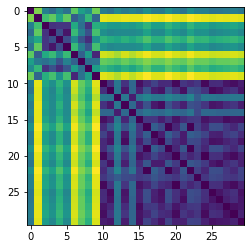

In [54]:
plt.figure(1)
plt.imshow(month_distance)
plt.show()